<h1 align="center">Coursera_Capstone_NY-Toronto_Neighbourhoods</h1>

<h2>Background</h2>

Employees do not tend to stay in a single organization forever. It is common for a resource to seek opportunities that best suits his aspirations and in his attenpt to satisfy requirements, seeks better opportunities outside current employment. However, better opportunity may also demand relocating to new places and it is difficult to find a suitable place to move with family and often results in multiple enquiries and prolonged decision making process while selecting a best neighbourhood and still does not ensure satisfaction.



<h2>Problem</h2>

This use case will center around an employee named Luke, who is currently residing in New York in the manhatten area and has found a suitable Job opportunity in Scarborough, Toronto. He has never been to Toronto and has limited friends in that area. He is not satisfied with his research and the locations suggested to him by friends and agents. He is looking for neighbourhoods similar to his current neighbourhood.

Can we find neighbourhoods in Toronto that are similar to Like's current area of residence?

<h2>Data</h2>

In order to answer the question at hand, we would need the Newyork geo data pertaining to Luke's current area of residence. Additionally in order to find the venues associated with his current residence, we would need to source venue data from foursquate or Google. New York geo data is available at https://geo.nyu.edu/catalog/nyu_2451_34572. 
Similar geo data will be required to be sourced for Toronto, Scarborough. Geo data for Toronto is available at https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M , Geospacial data from links provided in the labs, and venue category data from either foursquare or google.

The City geo data in general will have Borough, neighborhood, latitude longitude mainly.
venmue foursquare data will be extracted based on the latitude and longitude data of the Neighborhoods around a radius and limited by certain number of data sets due to computation limitations. venue data will be used mainly the category data so as to arrive at similarity scores in order to match the current neighborhood with the new neighborhood.

<h2>Methodology</h2>

Approach: Lukes current geo data and venue data will provide with top 10 venues in his current locality. This data will be matched with the venues within clusters in Scarborough that we will arrive at with our model. 

In [104]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

lukes_current_Borough="Manhattan"
lukes_current_Neighborhood="Washington Heights"
lukes_new_Borough="Scarborough"
lukes_new_Neighbourhood="TBD"
CLIENT_ID = '2FDXUDVAQPG5FZ4WWYGT34G2TM1CKBA2JPQCGFTM1Y5I0CJY' # your Foursquare ID
CLIENT_SECRET = '0WA4DSHALVQYC1ZNSLSXV5AXMD2II1SIC0GUVURTVG23KA25' # your Foursquare Secret
VERSION = '20180604'
LIMIT = 30
#print('Your credentails:')
#print('CLIENT_ID: ' + CLIENT_ID)
#print('CLIENT_SECRET:' + CLIENT_SECRET)
#!pip install lxml
#!python -m pip install --upgrade pip
#!pip install html5lib
#!pip install BeautifulSoup4

Libraries imported.


In [4]:
#functions
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]
#list = ['cat', 'bat', 'mat', 'cat', 'pet']
#print(len(list))
#findlist = ['cat', 'bat','mat', 'cat', 'pet1']
#clstr.shape[0]
import difflib
import re 

def score1(find,List):
    sum=0
    #print(List)
    if(len(find) == 1 and len(List) == 1):
        if(find[0] == List[0]):
            f=1
        else:
            f=0
        #print(find[0],List[0],f)
        return(f)
    else:

        for x in find:
            for y in List:
                sum += findinlist(re.findall(r'\w+', x),re.findall(r'\w+', y))
            #sum /= len(List)
        #print(sum/len(find))
        return(sum)

    import math

def counter_cosine_similarity(c1, c2):
    terms = set(c1).union(c2)
    dotprod = sum(c1.get(k, 0) * c2.get(k, 0) for k in terms)
    magA = math.sqrt(sum(c1.get(k, 0)**2 for k in terms))
    magB = math.sqrt(sum(c2.get(k, 0)**2 for k in terms))
    return dotprod / (magA * magB)
def length_similarity(c1, c2):
    lenc1 = sum(c1.itervalues())
    lenc2 = sum(c2.itervalues())
    return min(lenc1, lenc2) / float(max(lenc1, lenc2))

<h3> New York data processing</h3>
Newyork JSON data was populated into dataframes for Borough, Neighborhood, Latitude and Lonfitude to help come up with venue data.

In [7]:
#load data to df
#!wget -q -O 'newyork_data.json' https://cocl.us/new_york_dataset
#print('Data downloaded!')
import json
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)
ny_neighborhoods_data = newyork_data['features']

# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
ny_neighborhoods = pd.DataFrame(columns=column_names)

# push to data frame
for data in ny_neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    ny_neighborhoods = ny_neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
ny_neighborhoods.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


Using the geo latitude and longitude, the manatten venue data was arrived atgiving the basic dat areuiqred to come up with currnt neighborhood features.

In [20]:
manhattan_data = ny_neighborhoods[(ny_neighborhoods['Borough'] == lukes_current_Borough) & (ny_neighborhoods['Neighborhood'] == lukes_current_Neighborhood) ].reset_index(drop=True)
manhattan_data.head()
manhattan_venues = getNearbyVenues(names=manhattan_data['Neighborhood'],
                                   latitudes=manhattan_data['Latitude'],
                                   longitudes=manhattan_data['Longitude']
                                  )
manhattan_venues.head()

Washington Heights


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Washington Heights,40.851903,-73.9369,The Uptown Garrison,40.851255,-73.939473,Restaurant
1,Washington Heights,40.851903,-73.9369,Green Juice Cafe,40.851898,-73.934827,Café
2,Washington Heights,40.851903,-73.9369,Le Chéile,40.851459,-73.939989,Café
3,Washington Heights,40.851903,-73.9369,Saggio Restaurant,40.851423,-73.939761,Italian Restaurant
4,Washington Heights,40.851903,-73.9369,Burger Heights,40.850268,-73.934618,Burger Joint


In [22]:
#manhattan_venues.to_csv("manhattan_venues.csv")

Washington Heights in Manhattan data was further analysed based on the Venue category data imported earlier from foursquare and mean figures of frequency of occurance of the venues was arrived at.

In [23]:
#Analyse Manhatten neighbouthood venues
# one hot encoding
manhattan_onehot = pd.get_dummies(manhattan_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
manhattan_onehot['Neighborhood'] = manhattan_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [manhattan_onehot.columns[-1]] + list(manhattan_onehot.columns[:-1])
manhattan_onehot = manhattan_onehot[fixed_columns]

manhattan_onehot.head()
manhattan_grouped = manhattan_onehot.groupby('Neighborhood').mean().reset_index()
manhattan_grouped

,Neighborhood,American Restaurant,Bakery,Breakfast Spot,Burger Joint,Café,Caribbean Restaurant,Cocktail Bar,Deli / Bodega,Frozen Yogurt Shop,Indian Restaurant,Italian Restaurant,Latin American Restaurant,Liquor Store,Market,Mobile Phone Shop,New American Restaurant,Park,Pizza Place,Pool,Ramen Restaurant,Restaurant,Scenic Lookout,Tapas Restaurant,Wine Shop
0,Washington Heights,0.033333,0.066667,0.033333,0.033333,0.066667,0.033333,0.033333,0.066667,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.066667,0.033333,0.033333,0.033333,0.033333,0.033333,0.066667,0.066667


Top 10 venues were derived form the data so as to have a basis for matching the toronto cluster data in similar format.

In [24]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
ny_neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
ny_neighborhoods_venues_sorted['Neighborhood'] = manhattan_grouped['Neighborhood']

for ind in np.arange(manhattan_grouped.shape[0]):
    ny_neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(manhattan_grouped.iloc[ind, :], num_top_venues)

ny_neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Washington Heights,Wine Shop,Bakery,Café,Park,Deli / Bodega,Tapas Restaurant,Italian Restaurant,Breakfast Spot,Burger Joint,Caribbean Restaurant


<h4>Result of NY data analysis: we get Lukes current Neighbourhood top 10 venues</h4>

<h3>Toronto Data Analysis</h3>


Toronto data was obtained from wiki links and scraped of from the site to get the Borough, neighborhood data, which was further sanitized

In [25]:
#scrape toronto data to dataframe
url = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
df = pd.read_html(url, attrs={'class': 'wikitable'})

#remove not assigned Borough, update not assined neighbourhood equal to borough,
df1 = pd.DataFrame(df[0][df[0].Borough != 'Not assigned'])
df1.loc[df1.Neighbourhood == 'Not assigned','Neighbourhood'] = df1.loc[df1.Neighbourhood == 'Not assigned'].Borough
df1.head() 

,Postcode,Borough,Neighbourhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront
5,M5A,Downtown Toronto,Regent Park
6,M6A,North York,Lawrence Heights


Geo spacial data was merged with the wiki data to get a similar dataframe as the NEw York data to arrive at the base toronto data.

In [27]:
#get geospacial data for PostCode and merge with the oronto dataframe
gs_df=pd.read_csv("Geospatial_Coordinates.csv")
gs_df.head()
tor_neighborhoods = pd.merge(df1, gs_df, left_on=['Postcode'],
              right_on=['Postal Code'],
              how='left')
tor_neighborhoods.shape
tor_neighborhoods.drop(['Postal Code'], axis = 1,inplace=True)
tor_neighborhoods.head()

,Postcode,Borough,Neighbourhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,Harbourfront,43.654260,-79.360636
3,M5A,Downtown Toronto,Regent Park,43.654260,-79.360636
4,M6A,North York,Lawrence Heights,43.718518,-79.464763


Toronto data was further augmented with venue data from foursquare using the web api

In [31]:
target_data = pd.DataFrame(tor_neighborhoods[tor_neighborhoods['Borough'] == lukes_new_Borough].reset_index(drop=True))
target_data.shape
target_venues = getNearbyVenues(names=target_data['Neighbourhood'],
                                   latitudes=target_data['Latitude'],
                                   longitudes=target_data['Longitude']
                                  )
target_venues.head()

Rouge
Malvern
Highland Creek
Rouge Hill
Port Union
Guildwood
Morningside
West Hill
Woburn
Cedarbrae
Scarborough Village
East Birchmount Park
Ionview
Kennedy Park
Clairlea
Golden Mile
Oakridge
Cliffcrest
Cliffside
Scarborough Village West
Birch Cliff
Cliffside West
Dorset Park
Scarborough Town Centre
Wexford Heights
Maryvale
Wexford
Agincourt
Clarks Corners
Sullivan
Tam O'Shanter
Agincourt North
L'Amoreaux East
Milliken
Steeles East
L'Amoreaux West
Upper Rouge


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Rouge,43.806686,-79.194353,Wendy's,43.807448,-79.199056,Fast Food Restaurant
1,Malvern,43.806686,-79.194353,Wendy's,43.807448,-79.199056,Fast Food Restaurant
2,Highland Creek,43.784535,-79.160497,Royal Canadian Legion,43.782533,-79.163085,Bar
3,Rouge Hill,43.784535,-79.160497,Royal Canadian Legion,43.782533,-79.163085,Bar
4,Port Union,43.784535,-79.160497,Royal Canadian Legion,43.782533,-79.163085,Bar


In [32]:
#target_venues.to_csv("target_venues.csv")

Toronto neighborhood data was analysed for venue category and encoding was appliued so as to form the basis of getting first 10 venues. Mean of frequency of venues was arrived at which was later utilized for clustering.

In [33]:
#Analyse Toronto neighbouthood venues
# one hot encoding
target_onehot = pd.get_dummies(target_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
target_onehot['Neighborhood'] = target_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [target_onehot.columns[-1]] + list(target_onehot.columns[:-1])
target_onehot = target_onehot[fixed_columns]

target_onehot.head()
target_grouped = target_onehot.groupby('Neighborhood').mean().reset_index()
target_grouped

,Neighborhood,American Restaurant,Athletics & Sports,Auto Garage,Bakery,Bank,Bar,Breakfast Spot,Bus Line,Bus Station,Café,Caribbean Restaurant,Chinese Restaurant,Coffee Shop,College Stadium,Convenience Store,Department Store,Discount Store,Electronics Store,Fast Food Restaurant,Fried Chicken Joint,General Entertainment,Grocery Store,Hakka Restaurant,Indian Restaurant,Insurance Office,Intersection,Italian Restaurant,Japanese Restaurant,Korean Restaurant,Latin American Restaurant,Lounge,Medical Center,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Motel,Noodle House,Park,Pet Store,Pharmacy,Pizza Place,Playground,Rental Car Location,Sandwich Place,Shopping Mall,Skating Rink,Smoke Shop,Soccer Field,Spa,Thai Restaurant,Vietnamese Restaurant
0,Agincourt,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.250000,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.00,0.0,0.00,0.00,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.00,0.000000,0.0,0.000000,0.00,0.000000,0.25,0.000,0.000000,0.000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.250000,0.000000,0.25,0.000000,0.000000,0.000,0.000000,0.000000
1,Agincourt North,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.333333,0.00,0.0,0.00,0.00,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.00,0.000000,0.0,0.000000,0.00,0.000000,0.00,0.000,0.000000,0.000,0.000000,0.0,0.0,0.333333,0.000000,0.000000,0.000000,0.333333,0.000,0.000000,0.000000,0.00,0.000000,0.000000,0.000,0.000000,0.000000
2,Birch Cliff,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.00,0.25,0.000000,0.000000,0.000000,0.25,0.0,0.00,0.00,0.000000,0.000000,0.000000,0.25,0.000000,0.000000,0.000000,0.00,0.000000,0.0,0.000000,0.00,0.000000,0.00,0.000,0.000000,0.000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.25,0.000000,0.000000,0.000,0.000000,0.000000
3,Cedarbrae,0.0,0.142857,0.000000,0.142857,0.142857,0.0,0.000000,0.000000,0.00,0.00,0.142857,0.000000,0.000000,0.00,0.0,0.00,0.00,0.000000,0.000000,0.142857,0.00,0.000000,0.142857,0.000000,0.00,0.000000,0.0,0.000000,0.00,0.000000,0.00,0.000,0.000000,0.000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.00,0.000000,0.000000,0.000,0.142857,0.000000
4,Clairlea,0.0,0.000000,0.000000,0.222222,0.000000,0.0,0.000000,0.222222,0.00,0.00,0.000000,0.000000,0.000000,0.00,0.0,0.00,0.00,0.000000,0.111111,0.000000,0.00,0.000000,0.000000,0.000000,0.00,0.111111,0.0,0.000000,0.00,0.000000,0.00,0.000,0.111111,0.000,0.000000,0.0,0.0,0.111111,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.00,0.000000,0.111111,0.000,0.000000,0.000000
5,Clarks Corners,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.00,0.00,0.000000,0.100000,0.000000,0.00,0.0,0.00,0.00,0.000000,0.100000,0.100000,0.00,0.000000,0.000000,0.000000,0.00,0.000000,0.1,0.000000,0.00,0.000000,0.00,0.000,0.000000,0.000,0.000000,0.0,0.1,0.000000,0.000000,0.100000,0.200000,0.000000,0.100,0.000000,0.000000,0.00,0.000000,0.000000,0.000,0.100000,0.000000
6,Cliffcrest,0.5,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.00,0.0,0.00,0.00,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.00,0.000000,0.0,0.000000,0.00,0.000000,0.00,0.000,0.000000,0.000,0.000000,0.5,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.00,0.000000,0.000000,0.000,0.000000,0.000000
7,Cliffside,0.5,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.00,0.0,0.00,0.00,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.00,0.000000,0.0,0.000000,0.00,0.000000,0.00,0.000,0.000000,0.000,0.000000,0.5,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.00,0.000000,0.000000,0.000,0.000000,0.000000
8,Cliffside West,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.00,0.25,0.000000,0.000000,0.000000,0

From the processed data, top 10 venue was arrived at.

In [34]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
selcols = []
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
        selcols.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))
        selcols.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
tor_neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
tor_neighborhoods_venues_sorted['Neighborhood'] = target_grouped['Neighborhood']

for ind in np.arange(target_grouped.shape[0]):
    tor_neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(target_grouped.iloc[ind, :], num_top_venues)

tor_neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agincourt,Skating Rink,Sandwich Place,Breakfast Spot,Lounge,Vietnamese Restaurant,Coffee Shop,Grocery Store,General Entertainment,Fried Chicken Joint,Fast Food Restaurant
1,Agincourt North,Park,Playground,Coffee Shop,Chinese Restaurant,Grocery Store,General Entertainment,Fried Chicken Joint,Fast Food Restaurant,Electronics Store,Discount Store
2,Birch Cliff,General Entertainment,Skating Rink,Café,College Stadium,Vietnamese Restaurant,Coffee Shop,Hakka Restaurant,Grocery Store,Fried Chicken Joint,Fast Food Restaurant
3,Cedarbrae,Thai Restaurant,Athletics & Sports,Bakery,Bank,Hakka Restaurant,Fried Chicken Joint,Caribbean Restaurant,Convenience Store,Indian Restaurant,Grocery Store
4,Clairlea,Bakery,Bus Line,Intersection,Fast Food Restaurant,Metro Station,Park,Soccer Field,Bank,Convenience Store,Grocery Store


<h4>we were able to get the venue catogory frequency of all lukes {lukes_new_Borough} neighbourhoods</h4>

<h3>Matching Lukes current Venues against clusters drawn for toronto's neighbourhood venues</h3>


Data Preparation once complete, clustering was taken up for the similarity mathcing. kmeans clustering technique wad used. Elbow curev was plotted to see how the score would vary with the clusters size. It was observed that saturation reached at around 15 size.

In [234]:
from sklearn.metrics.cluster import adjusted_rand_score
import pylab as pl
%matplotlib inline

d:\program files\python\python37\lib\site-packages\sklearn\cluster\k_means_.py:971: ConvergenceWarning: Number of distinct clusters (16) found smaller than n_clusters (17). Possibly due to duplicate points in X.
  return_n_iter=True)
d:\program files\python\python37\lib\site-packages\sklearn\cluster\k_means_.py:971: ConvergenceWarning: Number of distinct clusters (16) found smaller than n_clusters (18). Possibly due to duplicate points in X.
  return_n_iter=True)
d:\program files\python\python37\lib\site-packages\sklearn\cluster\k_means_.py:971: ConvergenceWarning: Number of distinct clusters (16) found smaller than n_clusters (19). Possibly due to duplicate points in X.
  return_n_iter=True)


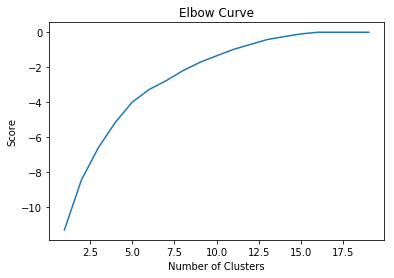

In [235]:
Nc = range(1, 20)

kmeans = [KMeans(n_clusters=i) for i in Nc]

kmeans

score = [kmeans[i].fit(target_grouped_clustering).score(target_grouped_clustering) for i in range(len(kmeans))]

score

pl.plot(Nc,score)

pl.xlabel('Number of Clusters')

pl.ylabel('Score')

pl.title('Elbow Curve')

pl.show()

In [236]:
#cluster targets so that we can get match scores against clusters which can then be suggested to Luke
# set number of clusters
kclusters = 15

target_grouped_clustering = target_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(target_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 



array([14,  4,  8, 13, 10,  6,  7,  7,  8,  5])

Venue data was merged with Borough and Neighborhood data to arrive at the final dataset for similarity comparison which now had cluster details as well.

In [237]:
#Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

# add clustering labels
#tor_neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
#tor_neighborhoods_venues_sorted.head()
target_merged = pd.DataFrame(target_data)

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
target_merged = target_merged.join(tor_neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighbourhood')

target_merged.head() # check the last columns!

,Postcode,Borough,Neighbourhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M1B,Scarborough,Rouge,43.806686,-79.194353,3.0,Fast Food Restaurant,Vietnamese Restaurant,Coffee Shop,Hakka Restaurant,Grocery Store,General Entertainment,Fried Chicken Joint,Electronics Store,Discount Store,Department Store
1,M1B,Scarborough,Malvern,43.806686,-79.194353,3.0,Fast Food Restaurant,Vietnamese Restaurant,Coffee Shop,Hakka Restaurant,Grocery Store,General Entertainment,Fried Chicken Joint,Electronics Store,Discount Store,Department Store
2,M1C,Scarborough,Highland Creek,43.784535,-79.160497,0.0,Bar,Vietnamese Restaurant,Coffee Shop,Hakka Restaurant,Grocery Store,General Entertainment,Fried Chicken Joint,Fast Food Restaurant,Electronics Store,Discount Store
3,M1C,Scarborough,Rouge Hill,43.784535,-79.160497,0.0,Bar,Vietnamese Restaurant,Coffee Shop,Hakka Restaurant,Grocery Store,General Entertainment,Fried Chicken Joint,Fast Food Restaurant,Electronics Store,Discount Store
4,M1C,Scarborough,Port Union,43.784535,-79.160497,0.0,Bar,Vietnamese Restaurant,Coffee Shop,Hakka Restaurant,Grocery Store,General Entertainment,Fried Chicken Joint,Fast Food Restaurant,Electronics Store,Discount Store


In [249]:
cls = target_merged.loc[target_merged['Cluster Labels'] == 4, target_merged.columns[[1] + list(range(5, target_merged.shape[1]))]].reset_index(drop=True)
cls


,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Scarborough,4.0,Coffee Shop,Insurance Office,Korean Restaurant,Hakka Restaurant,Grocery Store,General Entertainment,Fried Chicken Joint,Fast Food Restaurant,Electronics Store,Discount Store
1,Scarborough,4.0,Playground,Convenience Store,Vietnamese Restaurant,Coffee Shop,Hakka Restaurant,Grocery Store,General Entertainment,Fried Chicken Joint,Fast Food Restaurant,Electronics Store
2,Scarborough,4.0,Park,Playground,Coffee Shop,Chinese Restaurant,Grocery Store,General Entertainment,Fried Chicken Joint,Fast Food Restaurant,Electronics Store,Discount Store
3,Scarborough,4.0,Park,Playground,Coffee Shop,Chinese Restaurant,Grocery Store,General Entertainment,Fried Chicken Joint,Fast Food Restaurant,Electronics Store,Discount Store
4,Scarborough,4.0,Park,Playground,Coffee Shop,Chinese Restaurant,Grocery Store,General Entertainment,Fried Chicken Joint,Fast Food Restaurant,Electronics Store,Discount Store
5,Scarborough,4.0,Park,Playground,Coffee Shop,Chinese Restaurant,Grocery Store,General Entertainment,Fried Chicken Joint,Fast Food Restaurant,Electronics Store,Discount Store


<h4>Similarity comparison</h4>

Similarity was computed between NY top venue data with clusters for toronto data. Certain generalization was made during comparison such that commonalty amongst venues was considered as a match e.g restaurant was considered as a similarity for various kinfds of restaurants.

In [250]:
#analyse each cluster with a score that is obtained by 
#finding matching venue category in the current neighborhood and the targetted neighborhood

cluster_scores=[]
print(ny_neighborhoods_venues_sorted.loc[0:1,selcols].values.tolist())
for n in range(0,5):
    #print('cluster', n)
    clstr = pd.DataFrame()
    clstr = target_merged.loc[target_merged['Cluster Labels'] == n, target_merged.columns[[1] + list(range(5, target_merged.shape[1]))]].reset_index(drop=True)
    sum_score=0
    for i in range(0,clstr.shape[0]):
        #print('cluster', n, 'row',i)
        current_list = ny_neighborhoods_venues_sorted.loc[0:1,selcols].values.tolist()
        target_list = clstr.loc[i:i,selcols].values.tolist()
        #sum_score += adjusted_rand_score(current_list,target_list)
        sum_score += score1(current_list[0],target_list[0])
    cluster_scores.append(sum_score/clstr.shape[0])
cluster_scores

[['Wine Shop', 'Bakery', 'Café', 'Park', 'Deli / Bodega', 'Tapas Restaurant', 'Italian Restaurant', 'Breakfast Spot', 'Burger Joint', 'Caribbean Restaurant']]


[4.833333333333333,
 4.662878787878787,
 4.333333333333333,
 4.833333333333334,
 4.499999999999999]

<h2>Results</h2>

Cluster 0 and 3 have highest similarity and would indicate a better suggestion to Luke though, the deviation is small. 

<h2>Discussion</h2>

One can drill down the similarity computation to neighborhood level and can further provide exact neighborood as a suggestion as well. Different similarity computation can be done and results compared. Similarity result will become more crisp if more venue can be added over and above the top 10 venues we limited to in this PoC. Suggestions can also include Lukes other preferences but has not been included in the scope of the study. Other clustering methods can also be studied as future work.

<h2>Conclusion</h2>

Employees continue to look for better opportunities and relocation does not pose a limitation if such methodologies are adopted to come up with informed decisions before relaocation is finalized. It also saves om cost due to multiple visits to chose a best locality to live.